<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/process_control_with_neqsim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title Process Control in NeqSim
#@markdown This notebook introduces basic process control concepts and shows how they can be implemented in the [NeqSim](https://neqsim.github.io/neqsimpython/) process simulator.
%%capture
!pip install neqsim matplotlib
from neqsim import jneqsim
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo


In [6]:
#@title Video: Process Control Basics
#@markdown A short introduction to process control concepts.
YouTubeVideo('FEnwYVPDRDE', width=600, height=400)

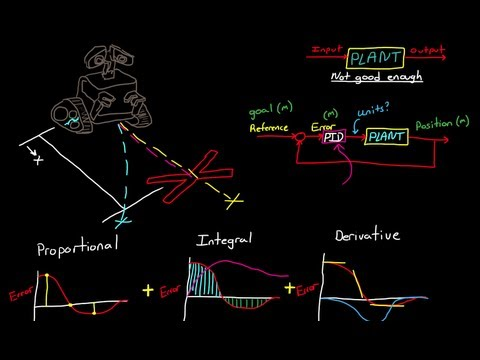

In [7]:
#@title Video: PID Controller Explained
#@markdown Understanding proportional-integral-derivative control.
YouTubeVideo('UR0hOmjaHp0', width=600, height=400)

## Process control theory
Process control keeps process variables such as pressure, flow or level close to desired setpoints. The process itself is described by dynamic mass and energy balances that respond to changes in manipulated variables. Feedback controllers (P, PI and PID) compare a measured value with the setpoint and manipulate an actuator to reduce the error. The proportional term gives an immediate correction, the integral term removes any steady-state offset by accumulating error over time, and the derivative term anticipates future error by considering the rate of change. Proper tuning of these terms is essential to maintain stability and achieve fast, well-damped responses.


## Control options in NeqSim
NeqSim supports dynamic simulation with measurement devices (transmitters) and controller devices. Each unit operation exposes variables that can be measured and manipulated, enabling the construction of control loops. Controllers can be attached to valves or other equipment and tuned by specifying proportional (K$_p$), integral (T$_i$) and derivative (T$_d$) parameters. The simulator integrates the underlying differential equations so that closed-loop behaviour, interaction between loops and the effect of disturbances can be studied in detail.


## Example: controlling separator level and pressure
The example below shows a simple separator with control of both liquid level and gas outlet pressure. A level transmitter and a pressure transmitter provide measurements which are used by PID controllers connected to outlet valves. The level controller manipulates the liquid valve to balance inflow and outflow, while the pressure controller manipulates the gas valve to match gas generation with export capacity. The two loops illustrate typical process control concepts such as controlled variables, manipulated variables and the potential for loop interaction.


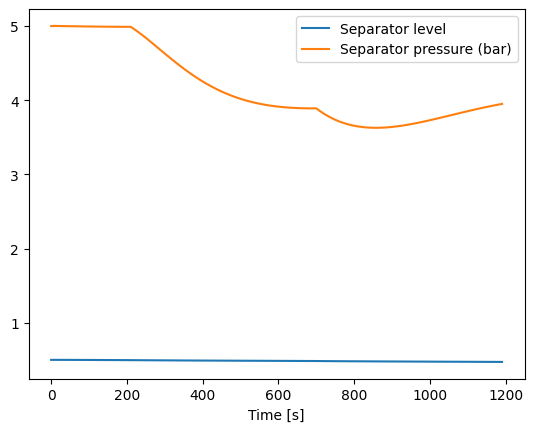

In [28]:
# define the feed fluid
fluid1 = jneqsim.thermo.system.SystemSrkEos(298.15, 10.0)
fluid1.addComponent("methane", 0.9)
fluid1.addComponent("ethane", 0.1)
fluid1.addComponent("n-heptane", 1.0)
fluid1.setMixingRule('classic')

# build process equipment
feed = jneqsim.process.equipment.stream.Stream("Feed", fluid1)
feed.setFlowRate(50.0, "kg/hr")
feed.setPressure(10.0, "bara")

inlet_valve = jneqsim.process.equipment.valve.ThrottlingValve("inlet valve", feed)
inlet_valve.setOutletPressure(5.0)
inlet_valve.setPercentValveOpening(30)
inlet_valve.setCalculateSteadyState(False)

sep = jneqsim.process.equipment.separator.Separator("Separator")
sep.addStream(inlet_valve.getOutletStream())
sep.setSeparatorLength(0.3)
sep.setInternalDiameter(1.0)
sep.setLiquidLevel(0.5)
sep.setCalculateSteadyState(False)


liq_valve = jneqsim.process.equipment.valve.ThrottlingValve("liquid valve", sep.getLiquidOutStream())
liq_valve.setOutletPressure(1.0)
liq_valve.setPercentValveOpening(50)
liq_valve.setCalculateSteadyState(False)

gas_valve = jneqsim.process.equipment.valve.ThrottlingValve("gas valve", sep.getGasOutStream())
gas_valve.setOutletPressure(1.0)
gas_valve.setPercentValveOpening(50)
gas_valve.setCalculateSteadyState(False)

# measurement devices
level_trans = jneqsim.process.measurementdevice.LevelTransmitter(sep)
level_trans.setMaximumValue(0.8)
level_trans.setMinimumValue(0.2)

pressure_trans = jneqsim.process.measurementdevice.PressureTransmitter(sep.getGasOutStream())
pressure_trans.setUnit("bar")
pressure_trans.setMaximumValue(10.0)
pressure_trans.setMinimumValue(1.0)

# controllers
level_contr = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
level_contr.setReverseActing(False)
level_contr.setTransmitter(level_trans)
level_contr.setControllerSetPoint(0.45)
level_contr.setControllerParameters(1.0, 200.0, 0.0)

pressure_contr = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
pressure_contr.setReverseActing(False)
pressure_contr.setTransmitter(pressure_trans)
pressure_contr.setControllerSetPoint(5.0)
pressure_contr.setControllerParameters(1.0, 50.0, 0.0)

liq_valve.setController(level_contr)
gas_valve.setController(pressure_contr)

# assemble and run process
p = jneqsim.process.processmodel.ProcessSystem()
p.add(feed)
p.add(inlet_valve)
p.add(sep)
p.add(liq_valve)
p.add(gas_valve)
p.add(level_trans)
p.add(pressure_trans)
p.run()

# dynamic simulation
p.setTimeStep(10.0)

time=[]; level=[]; pressure=[]
for i in range(20):
    time.append(p.getTime())
    level.append(level_trans.getMeasuredValue())
    pressure.append(pressure_trans.getMeasuredValue())
    p.runTransient()

pressure_contr.setControllerSetPoint(4.0)

for i in range(50):
    time.append(p.getTime())
    level.append(level_trans.getMeasuredValue())
    pressure.append(pressure_trans.getMeasuredValue())
    p.runTransient()

feed.setPressure(8.0, "bara")
level_contr.setControllerSetPoint(0.5)

for i in range(50):
    time.append(p.getTime())
    level.append(level_trans.getMeasuredValue())
    pressure.append(pressure_trans.getMeasuredValue())
    p.runTransient()


plt.plot(time, level, label='Separator level')
plt.plot(time, pressure, label='Separator pressure (bar)')
plt.xlabel('Time [s]')
plt.legend()
plt.show()


The plot shows how the PID controllers keep level and pressure close to their setpoints and how the pressure responds when the setpoint is changed from 5 to 4 bar. The transient reveals the characteristic behaviour of a tuned PI loop with a moderate overshoot followed by exponential decay toward the new steady state.


## Two-stage separation with recompression
The following example extends the previous case by adding a second-stage separator. Flash gas from this stage is recompressed and mixed with gas from the inlet separator to form the export gas stream. Multi-stage separation improves liquid recovery by sequentially flashing the mixture at lower pressures, while recompressing the second-stage gas maintains overall gas throughput.


In [ ]:
#@title Two-stage separation with recompression
# build feed fluid
fluid2 = jneqsim.thermo.system.SystemSrkEos(298.15, 20.0)
fluid2.addComponent('methane', 0.9)
fluid2.addComponent('ethane', 0.1)
fluid2.addComponent('n-heptane', 1.0)
fluid2.setMixingRule('classic')

feed2 = jneqsim.process.equipment.stream.Stream('Feed', fluid2)
feed2.setFlowRate(50.0, 'kg/hr')
feed2.setPressure(20.0, 'bara')

# first stage separation
valve1 = jneqsim.process.equipment.valve.ThrottlingValve('inlet valve', feed2)
valve1.setOutletPressure(10.0)
valve1.setCalculateSteadyState(False)

sep1 = jneqsim.process.equipment.separator.Separator('1st stage')
sep1.addStream(valve1.getOutletStream())
sep1.setSeparatorLength(0.3)
sep1.setInternalDiameter(1.0)
sep1.setCalculateSteadyState(False)

# second stage separation
valve2 = jneqsim.process.equipment.valve.ThrottlingValve('interstage valve', sep1.getLiquidOutStream())
valve2.setOutletPressure(5.0)
valve2.setCalculateSteadyState(False)

sep2 = jneqsim.process.equipment.separator.Separator('2nd stage')
sep2.addStream(valve2.getOutletStream())
sep2.setSeparatorLength(0.3)
sep2.setInternalDiameter(1.0)
sep2.setCalculateSteadyState(False)

# recompress flash gas
comp = jneqsim.process.equipment.compressor.Compressor('recompressor', sep2.getGasOutStream())
comp.setOutletPressure(10.0)
comp.setCalculateSteadyState(False)

# mix export gas
mixer = jneqsim.process.equipment.mixer.Mixer('export mixer')
mixer.addStream(sep1.getGasOutStream())
mixer.addStream(comp.getOutletStream())

# level control in both separators
level1_trans = jneqsim.process.measurementdevice.LevelTransmitter(sep1)
level1_trans.setMaximumValue(0.8)
level1_trans.setMinimumValue(0.2)
level2_trans = jneqsim.process.measurementdevice.LevelTransmitter(sep2)
level2_trans.setMaximumValue(0.8)
level2_trans.setMinimumValue(0.2)

level1_ctrl = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
level1_ctrl.setReverseActing(False)
level1_ctrl.setTransmitter(level1_trans)
level1_ctrl.setControllerSetPoint(0.5)
level1_ctrl.setControllerParameters(1.0, 200.0, 0.0)

level2_ctrl = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
level2_ctrl.setReverseActing(False)
level2_ctrl.setTransmitter(level2_trans)
level2_ctrl.setControllerSetPoint(0.5)
level2_ctrl.setControllerParameters(1.0, 200.0, 0.0)

liq1_valve = jneqsim.process.equipment.valve.ThrottlingValve('1st stage liquid valve', sep1.getLiquidOutStream())
liq1_valve.setOutletPressure(1.0)
liq1_valve.setPercentValveOpening(50)
liq1_valve.setCalculateSteadyState(False)
liq1_valve.setController(level1_ctrl)

liq2_valve = jneqsim.process.equipment.valve.ThrottlingValve('2nd stage liquid valve', sep2.getLiquidOutStream())
liq2_valve.setOutletPressure(1.0)
liq2_valve.setPercentValveOpening(50)
liq2_valve.setCalculateSteadyState(False)
liq2_valve.setController(level2_ctrl)

# assemble process
p2 = jneqsim.process.processmodel.ProcessSystem()
p2.add(feed2)
p2.add(valve1)
p2.add(sep1)
p2.add(valve2)
p2.add(sep2)
p2.add(comp)
p2.add(mixer)
p2.add(liq1_valve)
p2.add(liq2_valve)
p2.add(level1_trans)
p2.add(level2_trans)
p2.run()

# dynamic simulation and step response
p2.setTimeStep(10.0)

s_time = []
s_pressure = []
for i in range(20):
    s_time.append(p2.getTime())
    s_pressure.append(mixer.getOutletStream().getPressure('bara'))
    p2.runTransient()

comp.setOutletPressure(12.0)

for i in range(50):
    s_time.append(p2.getTime())
    s_pressure.append(mixer.getOutletStream().getPressure('bara'))
    p2.runTransient()

plt.plot(s_time, s_pressure, label='Export gas pressure')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()



The recompressed flash gas from the second stage is mixed with the gas from the inlet separator to produce the export stream. The plot above shows how the export gas pressure responds when the compressor set point is stepped from 10 to 12 bar. This step response illustrates how compressor dynamics and downstream volume determine the speed and damping of the pressure change.


### Advanced control options and step responses
NeqSim supports advanced control strategies such as cascade or ratio control in addition to basic PID loops. In cascade control a primary controller sets the setpoint of a faster secondary loop, thereby rejecting disturbances more quickly. Ratio control maintains a specified relationship between two flows or compositions by adjusting a secondary stream. Step response tests, sometimes called spring responses, can be performed by introducing set-point changes or disturbances and observing the transient behaviour. These responses are useful for tuning controllers, deriving approximate transfer functions and understanding process dynamics.


### Cascade and ratio control examples
The following examples demonstrate cascade control and ratio control using NeqSim's dynamic simulation capabilities. The cascade example shows an outer pressure loop that adjusts the setpoint of an inner flow loop, while the ratio example manipulates one stream to maintain a desired flow ratio to a reference stream.


In [ ]:
# Cascade control example
fluid_c = jneqsim.thermo.system.SystemSrkEos(298.15, 10.0)
fluid_c.addComponent('methane', 1.0)
fluid_c.setMixingRule('classic')

feed_c = jneqsim.process.equipment.stream.Stream('Feed', fluid_c)
feed_c.setFlowRate(50.0, 'kg/hr')
feed_c.setPressure(10.0, 'bara')

inlet_c = jneqsim.process.equipment.valve.ThrottlingValve('inlet valve', feed_c)
inlet_c.setOutletPressure(5.0)
inlet_c.setCalculateSteadyState(False)

sep_c = jneqsim.process.equipment.separator.Separator('Separator')
sep_c.addStream(inlet_c.getOutletStream())
sep_c.setSeparatorLength(0.3)
sep_c.setInternalDiameter(1.0)
sep_c.setCalculateSteadyState(False)

gas_valve_c = jneqsim.process.equipment.valve.ThrottlingValve('gas valve', sep_c.getGasOutStream())
gas_valve_c.setOutletPressure(1.0)
gas_valve_c.setPercentValveOpening(50.0)
gas_valve_c.setCalculateSteadyState(False)

# inner flow control
flow_trans = jneqsim.process.measurementdevice.VolumeFlowTransmitter(gas_valve_c.getOutletStream())
flow_trans.setMaximumValue(200.0)
flow_trans.setMinimumValue(0.0)
flow_ctrl = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
flow_ctrl.setReverseActing(True)
flow_ctrl.setTransmitter(flow_trans)
flow_ctrl.setControllerSetPoint(100.0)
flow_ctrl.setControllerParameters(1.0, 50.0, 0.0)
gas_valve_c.setController(flow_ctrl)

# outer pressure control
press_trans = jneqsim.process.measurementdevice.PressureTransmitter(sep_c.getGasOutStream())
press_trans.setUnit('bar')
press_trans.setMaximumValue(10.0)
press_trans.setMinimumValue(1.0)

p_c = jneqsim.process.processmodel.ProcessSystem()
p_c.add(feed_c)
p_c.add(inlet_c)
p_c.add(sep_c)
p_c.add(gas_valve_c)
p_c.add(flow_trans)
p_c.add(press_trans)
p_c.run()
p_c.setTimeStep(5.0)

outer_set = 5.0
Kp_outer = 10.0
time_c = []
pressure_c = []
for i in range(40):
    time_c.append(p_c.getTime())
    pressure_c.append(press_trans.getMeasuredValue())
    p_c.runTransient()
    error = outer_set - press_trans.getMeasuredValue()
    flow_ctrl.setControllerSetPoint(100.0 + Kp_outer * error)

feed_c.setPressure(12.0, 'bara')
for i in range(40):
    time_c.append(p_c.getTime())
    pressure_c.append(press_trans.getMeasuredValue())
    p_c.runTransient()
    error = outer_set - press_trans.getMeasuredValue()
    flow_ctrl.setControllerSetPoint(100.0 + Kp_outer * error)

plt.figure()
plt.plot(time_c, pressure_c, label='Separator pressure')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()


In [ ]:
# Ratio control example
fluid_r = jneqsim.thermo.system.SystemSrkEos(298.15, 20.0)
fluid_r.addComponent('methane', 1.0)
fluid_r.setMixingRule('classic')

a_stream = jneqsim.process.equipment.stream.Stream('A', fluid_r)
a_stream.setFlowRate(100.0, 'kg/hr')
a_stream.setPressure(20.0, 'bara')

b_stream = jneqsim.process.equipment.stream.Stream('B', fluid_r)
b_stream.setFlowRate(50.0, 'kg/hr')
b_stream.setPressure(20.0, 'bara')

b_valve = jneqsim.process.equipment.valve.ThrottlingValve('B valve', b_stream)
b_valve.setOutletPressure(20.0)
b_valve.setPercentValveOpening(50.0)
b_valve.setCalculateSteadyState(False)

mixer_r = jneqsim.process.equipment.mixer.Mixer('mix')
mixer_r.addStream(a_stream)
mixer_r.addStream(b_valve.getOutletStream())

a_trans = jneqsim.process.measurementdevice.VolumeFlowTransmitter(a_stream)
a_trans.setMaximumValue(200.0)
a_trans.setMinimumValue(0.0)
b_trans = jneqsim.process.measurementdevice.VolumeFlowTransmitter(b_valve.getOutletStream())
b_trans.setMaximumValue(200.0)
b_trans.setMinimumValue(0.0)

p_r = jneqsim.process.processmodel.ProcessSystem()
p_r.add(a_stream)
p_r.add(b_stream)
p_r.add(b_valve)
p_r.add(mixer_r)
p_r.add(a_trans)
p_r.add(b_trans)
p_r.run()
p_r.setTimeStep(5.0)

ratio_set = 0.5
Kp_ratio = 20.0
time_r = []
ratio = []
for i in range(40):
    fa = a_trans.getMeasuredValue()
    fb = b_trans.getMeasuredValue()
    ratio.append(fb/fa)
    time_r.append(p_r.getTime())
    error = ratio_set - fb/fa
    opening = b_valve.getPercentValveOpening() + Kp_ratio * error
    opening = max(0.0, min(100.0, opening))
    b_valve.setPercentValveOpening(opening)
    p_r.runTransient()

a_stream.setFlowRate(70.0, 'kg/hr')
for i in range(40):
    fa = a_trans.getMeasuredValue()
    fb = b_trans.getMeasuredValue()
    ratio.append(fb/fa)
    time_r.append(p_r.getTime())
    error = ratio_set - fb/fa
    opening = b_valve.getPercentValveOpening() + Kp_ratio * error
    opening = max(0.0, min(100.0, opening))
    b_valve.setPercentValveOpening(opening)
    p_r.runTransient()

plt.figure()
plt.plot(time_r, ratio, label='B/A ratio')
plt.axhline(ratio_set, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time [s]')
plt.ylabel('Flow ratio')
plt.legend()
plt.show()


### Step response tuning of PID regulators
Step (spring) responses are often used to tune PID regulators. By introducing a set-point change and observing the transient behaviour, tuning parameters can be adjusted to obtain a faster yet stable response. The example below compares an untuned controller with a tuned one controlling valve outlet pressure.


In [ ]:
# Step response tuning example
def run_step(Kp, Ki):
    fluid = jneqsim.thermo.system.SystemSrkEos(298.15, 50.0)
    fluid.addComponent('methane', 1.0)
    fluid.setMixingRule('classic')
    feed = jneqsim.process.equipment.stream.Stream('feed', fluid)
    feed.setFlowRate(100.0, 'kg/hr')
    feed.setPressure(50.0, 'bara')
    valve = jneqsim.process.equipment.valve.ThrottlingValve('valve', feed)
    valve.setOutletPressure(40.0)
    valve.setCalculateSteadyState(False)
    pt = jneqsim.process.measurementdevice.PressureTransmitter(valve.getOutletStream())
    pt.setUnit('bar')
    pt.setMaximumValue(60.0)
    pt.setMinimumValue(30.0)
    ctrl = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
    ctrl.setTransmitter(pt)
    ctrl.setControllerSetPoint(40.0)
    ctrl.setControllerParameters(Kp, Ki, 0.0)
    ctrl.setReverseActing(True)
    valve.setController(ctrl)
    p = jneqsim.process.processmodel.ProcessSystem()
    p.add(feed)
    p.add(valve)
    p.add(pt)
    p.run()
    p.setTimeStep(1.0)
    time = []
    pressure = []
    for i in range(20):
        time.append(p.getTime())
        pressure.append(pt.getMeasuredValue())
        p.runTransient()
    ctrl.setControllerSetPoint(45.0)
    for i in range(80):
        time.append(p.getTime())
        pressure.append(pt.getMeasuredValue())
        p.runTransient()
    return time, pressure

time_u, pressure_u = run_step(0.5, 0.0)
time_t, pressure_t = run_step(5.0, 1.0)
plt.figure()
plt.plot(time_u, pressure_u, label='Before tuning')
plt.plot(time_t, pressure_t, label='After tuning')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()


### Noise generation and filtering
NeqSim transmitters can generate measurement noise. The example below adds Gaussian noise to a pressure transmitter and applies a simple moving average filter to illustrate noise handling.


In [ ]:
# Noise generation and filtering example
fluid_n = jneqsim.thermo.system.SystemSrkEos(298.15, 10.0)
fluid_n.addComponent('methane', 1.0)
fluid_n.setMixingRule('classic')
feed_n = jneqsim.process.equipment.stream.Stream('feed', fluid_n)
feed_n.setFlowRate(100.0, 'kg/hr')
feed_n.setPressure(10.0, 'bara')
valve_n = jneqsim.process.equipment.valve.ThrottlingValve('valve', feed_n)
valve_n.setOutletPressure(1.0)
valve_n.setCalculateSteadyState(False)
pt_n = jneqsim.process.measurementdevice.PressureTransmitter(valve_n.getOutletStream())
pt_n.setUnit('bar')
pt_n.setMaximumValue(10.0)
pt_n.setMinimumValue(0.0)
pt_n.setNoiseStdDev(0.2)
p_n = jneqsim.process.processmodel.ProcessSystem()
p_n.add(feed_n)
p_n.add(valve_n)
p_n.add(pt_n)
p_n.run()
p_n.setTimeStep(1.0)
time_n = []
meas = []
filtered = []
for i in range(60):
    p_n.runTransient()
    time_n.append(p_n.getTime())
    val = pt_n.getMeasuredValue()
    meas.append(val)
    filtered.append(sum(meas[-5:]) / min(len(meas), 5))
plt.figure()
plt.plot(time_n, meas, label='Noisy measurement')
plt.plot(time_n, filtered, label='Filtered')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()
